Imports

In [20]:
# Basics
import re

# Multiprocessing
import multiprocess as mp
import concurrent.futures
import threading

# Data
import numpy as np
import pandas as pd
from matplotlib import pyplot

# Country codes
import pycountry

# Rasters - pixel data
import rasterio
from rasterio.plot import show
from rasterio.features import rasterize

# Polygons - country outlines
from shapely.geometry import Polygon
import geopandas as gpd
from countryoutlines import CountryOutlines  # custom class

# Custom classes for Hansen et al., 2013
from hansenhandler import HansenHandler, DataType
from tile import Tile


Get country ISO alpha 3 codes

In [2]:

# TODO add extra countries
countries = np.array([[country.alpha_3, country.name] for country in pycountry.countries])

Calculate bounds for each country

In [29]:
# countries_run = countries[:20]  # Can debug on a subset

try:
    # Here's one I made earlier
    df = pd.read_csv("interim/country_bounds.csv", index_col=[0,1])

except FileNotFoundError:
    # Code to create country bounds

    # Uses multiprocessing to speed up
    nProcesses = 2 * mp.cpu_count()

    with mp.get_context("spawn").Pool(nProcesses) as pool:
        # N.B. for countries spanning the date line,
        # two sets of bounds are created, one each side
        country_bounds = pool.starmap(CountryOutlines.get_bounds, countries)  

    # Combine calculations from different processes
    # TODO make index come out nicely
    df = pd.concat(country_bounds).reset_index().drop("index")
    # Save
    df.to_csv("interim/country_bounds.csv")



Create rectangle for calculations by tropics

<AxesSubplot:>

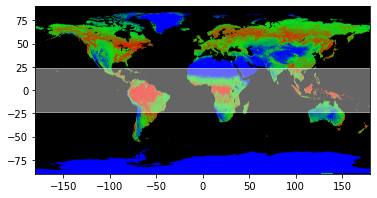

In [5]:

cancer = 23.4372
capricorn = -23.4394
tropics = Polygon([(-180,cancer),(-180,capricorn),(180,capricorn),(180,cancer)])
tropics = gpd.GeoDataFrame(geometry=[tropics])

plot = True
if plot:
    ax = tropics.plot(facecolor=(1,1,1,0.4), edgecolor='white', linewidth=0.5)

    with rasterio.open("raw/VCF5KYR_1982001_001_2018224204211.tif") as f:
        b1 = f.read(1)
        b2 = f.read(2)
        b3 = f.read(3)
        bands = np.stack((b1,b2,b3),axis=0) / 100

        show(bands, transform=f.transform, ax=ax)

    del b1, b2, b3, bands, f

Start computing means

In [6]:


hh = HansenHandler
# This code could maybe go in hansenhandler?
latlong = [(lat, long) for lat in range(-50,90,10) for long in range(-180,180,10)]

floor10 = lambda x: np.floor(x/10)*10
ceil10 = lambda x: np.ceil(x/10)*10
count_side = lambda start, end: (ceil10(end) - floor10(start)) / 10
count_tiles = lambda df: count_side(df.minx, df.maxx) * count_side(df.miny, df.maxy)

df = df.assign(nTiles = count_tiles)

df["nTiles"] = df.groupby("country")["nTiles"].transform("sum")





In [38]:
# Store outlines as they are being used
outlines = {country: None for country in df.country.unique()}

In [11]:
def read_band(raster, mask_band = None, window = None, return_affine=False):
    if window:
        band = raster.read(1, window=window)
        affine = raster.window_transform(window)
    else:
        band = raster.read(1) #, window=win)
        affine = raster.transform  # window_transform(win)

    # if mask_band:
    #     band[mask_band] = 255
    if return_affine:
        return (band, affine)
    else:
        return band

In [50]:
# Things start to take a long time and use a lot of memory from here
# so may move to Econ server

win = rasterio.windows.Window(20000,20000,21000,21000)

df[["code","area", "cover_2000", "gain", *(f"loss{y}" for y in range(1,21))]] = 0
print(df.columns)
i = 0
for coords in latlong:
    tile = Tile(*coords)
    # Subset countries whose bounds overlap
    countries = df[tile.covers_country(df)]
    
    # Check if no countries overlap
    if countries.empty:
        continue

    with tile.load_data(DataType.datamask) as mask_raster:
        mask, mask_affine = read_band(mask_raster, window=win, return_affine=True)
        
        # Check if the tile has no data
        # Might catch situations where country bounding box overlaps but country does not
        if not np.any(mask):
            continue

        area = np.random.random(mask.shape)
            
        with (tile.load_data(DataType.treecover2000) as cover_raster,
            tile.load_data(DataType.gain)            as gain_raster,
            tile.load_data(DataType.lossyear)        as lossyear_raster):

            # cover = read_band(cover_raster, window=win)
            # cover[cover <= 25] = 0
            # gain = read_band(gain_raster, window=win)
            # lossyear = read_band(lossyear_raster, window=win)
            countries = countries.droplevel("group")
            
            for c, row in countries.iterrows():
                # Load and save border if not already loaded
                country = row.country
                outline_gdf = outlines[country]
                if outline_gdf is None:
                    outlines[country] = outline_gdf = CountryOutlines.load_country(c)
                
                geom = outline_gdf.geometry
                
                # Or start here
                geom = rasterize(geom, out_shape=mask.shape, transform=mask_affine)
                
                # Check if geom is empty
                if not np.any(geom):
                    print(c, tile.lat, tile.long)
                    continue
                
                
                # Either start here
                # c for country
                mask_c      = mask * geom == 1
                area_c      = area[mask_c]
                # cover_c     = cover[mask_c]
                # lossyear_c  = lossyear[mask_c]
                # gain_c      = gain[mask_c]

                # _, n = np.unique(mask.flatten(), return_counts=True)
                
                df.loc[c,"area"] += area_c.sum()

                # Look into tensorflow one hot
                
                # df.loc[c,"cover_2000"] += (cover_c * area_c).sum()

                # df.loc[c, "gain"] += (gain_c * area_c).sum()

                # for year in range(1,20):
                #     yearmask = lossyear_c == year
                #     loss_cy = lossyear_c[yearmask]
                #     cover_cy = cover_c[yearmask]
                #     area_cy = area_c[yearmask]

                #     df.loc[c, f"loss_{year}"] += (loss_cy * cover_cy * area_cy).sum()

                
                # keys, counts = np.unique(mask_2.flatten(), return_counts=True)
                # pixel_count = dict(zip([k.item() for k in keys],
                #                         [c.item() for c in counts]))
                # feature_stats = dict(pixel_count)
                # print(feature_stats)
                i += 1
                if i > 0:
                    break
            





    




Index(['minx', 'miny', 'maxx', 'maxy', 'country', 'code', 'area, cover_2000',
       'gain', 'loss1', 'loss2', 'loss3', 'loss4', 'loss5', 'loss6', 'loss7',
       'loss8', 'loss9', 'loss10', 'loss11', 'loss12', 'loss13', 'loss14',
       'loss15', 'loss16', 'loss17', 'loss18', 'loss19', 'loss20', 'area',
       'cover_2000'],
      dtype='object')
ARG -50 -80
ATA -50 -80
ARG -50 -70
ATA -50 -70
CHL -50 -70
FLK -50 -70
ARG -40 -70
CHL -40 -70


In [ ]:
# Draft code for parallelisation

# def main(infile, outfile, num_workers=4):
#     """Process infile block-by-block and write to a new file

#     The output is the same as the input, but with band order
#     reversed.
#     """

#     with rasterio.open(infile) as src:

#         # Create a destination dataset based on source params. The
#         # destination will be tiled, and we'll process the tiles
#         # concurrently.
#         profile = src.profile
#         profile.update(blockxsize=128, blockysize=128, tiled=True)

#         with rasterio.open(outfile, "w", **src.profile) as dst:
#             windows = [window for ij, window in dst.block_windows()]

#             # We cannot write to the same file from multiple threads
#             # without causing race conditions. To safely read/write
#             # from multiple threads, we use a lock to protect the
#             # DatasetReader/Writer
#             read_lock = threading.Lock()
#             write_lock = threading.Lock()

#             def process(window):
#                 with read_lock:
#                     src_array = src.read(window=window)

#                 # The computation can be performed concurrently
#                 result = compute(src_array)

#                 with write_lock:
#                     dst.write(result, window=window)

#             # We map the process() function over the list of
#             # windows.
#             with concurrent.futures.ThreadPoolExecutor(
#                 max_workers=num_workers
#             ) as executor:
#                 executor.map(process, windows)
#         # For each 

        
#         #     cover, cover_affine = read_band(cover, mask)
#         #     write_pixel_counts(countries, df, )

In [46]:
def area_of_pixels(lat_start, lat_end, n_pixels):
    """Calculate m^2 area of an ndarray of wgs84 square pixels.

    Adapted from: https://gis.stackexchange.com/a/127327/2397
    
    """
    a = 6378137  # meters
    b = 6356752.3142  # meters
    e = np.sqrt(1 - (b/a)**2)
    lower = np.linspace(lat_start, lat_end, n_pixels, endpoint=False)
    
    higher = np.append(lower[1:], lat_end)
    pixel_size = (lat_end - lat_start) / n_pixels
    def subcalc(lats):
        sin_lats = np.sin(np.radians(lats))
        e_sin_lats = e*sin_lats
        zm = 1 - e_sin_lats
        zp = 1 + e_sin_lats
        return np.pi * b**2 * (np.arctanh(e_sin_lats) / e + sin_lats / (zp*zm))

    return pixel_size / 360. * (subcalc(higher) - subcalc(lower))

In [47]:
# area_of_pixels(0, )
test = "3077.2300079"  # official number for pixel going 30' north of equator
# TODO cite source

test2 = area_of_pixels(0,0.5,4)
test2 = test2 / 1000**2
np.tile(test2, (4,1)).sum()

3077.23000786937

In [ ]:
# Draft code to calculate extra countries


# """
# ['XSP: Spratly Islands_1', 'XCA: Caspian Sea_1', 'XKO: Kosovo_3', 'XPI: Paracel Islands_1', 'ZNC: Northern Cyprus_2', 'XAD: Not found', 'XCL: Not found']
# """

# test2 = 

# test = test.splitlines()
# test = [re.match(r'gadm40_(\w+).gpkg', line).groups()[0] for line in test]
# missing = set(test).difference(set([c.alpha_3 for c in pycountry.countries]))
# names = {c.alpha_3: c.name for c in pycountry.countries}
# missing

# test2 = test2.splitlines()
# test2 = [re.match(r'.*"([A-Z]+)_(.+)".*',line).groups() for line in test2]
# test2 = {k: v for (k,v) in test2}
# print([f"{k}: {test2[k]}" if k in test2 else f"{k}: Not found" for k in missing])
# m = re.match(r'.*"([A-Z]+)_([A-Za-z]+).*','<option value="VNM_Vietnam_4">Vietnam</option>')
# m.groups()
# countries